# Soft Binary Neural Network with Recurrent Crossbar Recycling

## Imports and Dataset

In [1]:
import numpy as np
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from torchinfo import summary
import ast
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def plot_history(history, num_epochs, element):
    epochs = range(len(history[list(history.keys())[0]]))
    
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    ax1.plot(epochs, history["train_loss"], label="Train Loss", color="blue")
    ax1.plot(epochs, history["val_loss"], label="Validation Loss", color="red")
    ax1.set_xlabel("Epochs", fontsize=14)
    ax1.set_ylabel("Loss", fontsize=14, color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_accuracy"], label="Train Accuracy", color="green")
    ax2.plot(epochs, history["val_accuracy"], label="Validation Accuracy", color="orange")
    ax2.set_ylabel("Accuracy (%)", fontsize=14, color="green")
    ax2.tick_params(axis="y", labelcolor="green")
    ax2.legend(loc="upper right")

    plt.title(f"Training and Validation Metrics for {element}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [3]:
def test(model, test_loader, class_names=None):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = (total_correct / total_samples) * 100

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")
    
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

### MNIST Handwritten Digits

In [4]:
class BinarizeAndAddNoiseTransform:
    def __init__(self, threshold=0.5, noise_std=0.01):
        self.threshold = threshold
        self.noise_std = noise_std

    def __call__(self, img):
        img = transforms.ToTensor()(img).to(device)
        img = (img > self.threshold).float()
        noise = torch.randn(img.size(), device=device) * self.noise_std
        noisy_img = img + noise
        return noisy_img

binary_noise_transform = transforms.Compose([
    BinarizeAndAddNoiseTransform(threshold=0.5, noise_std=0.05)
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=binary_noise_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=6000, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.60MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Get a subset of the dataset
train_in, train_lab = next(iter(train_loader))
val_in, val_lab = next(iter(test_loader))

# Move data to the appropriate device
train_in, train_lab = train_in.to(device), train_lab.to(device)
val_in, val_lab = val_in.to(device), val_lab.to(device)

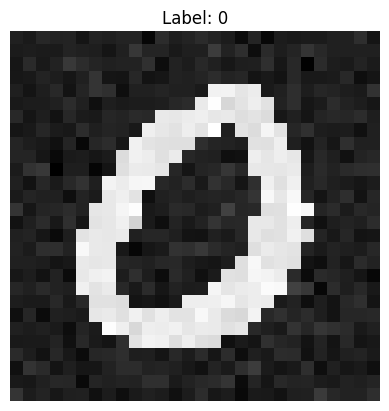

In [6]:
demo_ind = 1
plt.imshow(train_in[demo_ind].cpu().squeeze(), cmap='gray')
plt.title(f"Label: {train_lab[demo_ind].item()}")
plt.axis('off')
plt.show()

## Custom Neural Network

In [32]:
torch.backends.cudnn.benchmark = True

def tensor_stats(tensor, name="Tensor"):
    tensor = tensor.to(device)
    mean_magnitude = tensor.abs().mean().item()
    print(f"{name} - Mean Magnitude: {mean_magnitude:.2e}, Max: {tensor.max().item():.2e}, Min: {tensor.min().item():.2e}")

class SoftBinaryRecurrentForwardNetwork(nn.Module):
    def __init__(self, G_ON, G_OFF, V_INV, R_INV_1, R_INV_2, V_1, V_0, zeta, initial_factor, monitor_latents = False,
                 crossbar=(64,64), input_size=784, recurrence_size=32, output_size=10, int_norm=True, data_in = 28, 
                 bin_active=True, monitor_volts=False, monitor_grads =True, dropout=0.01, int_lr=0.01, Scaling = 1):
        super(SoftBinaryRecurrentForwardNetwork, self).__init__()

        # Crossbar Weights
        self.w = nn.Parameter(torch.empty(crossbar, device=device))
        nn.init.xavier_uniform_(self.w)
        self.w.data = initial_factor * self.w

        # Circuit Parameters
        self.G_ON = torch.tensor(G_ON, device=device)*Scaling
        self.G_OFF = torch.tensor(G_OFF, device=device)*Scaling
        self.V_INV = torch.tensor(V_INV, device=device)
        self.R_INV_1 = torch.tensor(R_INV_1, device=device)
        self.R_INV_2 = torch.tensor(R_INV_2, device=device) # Usually 3 or 4 times the first
        self.V_1 = torch.tensor(V_1, device=device)
        self.V_0 = torch.tensor(V_0, device=device)

        # Architecture Parameters
        self.crossbar_in = crossbar[0]
        self.crossbar_out = crossbar[1]
        
        self.feedback = recurrence_size
        self.data_in = data_in
        self.first_bias = crossbar[0] - recurrence_size - data_in
        self.r_passes = input_size // self.data_in
        
        self.second_layer = crossbar[1] - output_size - recurrence_size

        self.final_bias = crossbar[0] - 2*self.second_layer
        self.output_size = output_size
        
        # Training Variables
        self.zeta = torch.tensor(zeta, device=device)
        self.monitor_volts = monitor_volts
        self.monitor_grads = monitor_grads
        self.monitor_latents = monitor_latents
        self.dropout = nn.Dropout(p=dropout)
        self.int_lr = torch.tensor(int_lr, device=device)
        self.int_norm = int_norm
        self.bin_active = bin_active

    def INV_AMP(self, x, R_INV):
        return -self.V_INV * torch.tanh(R_INV * x / self.V_INV)

    def SOFT_BIN(self, x):
        if self.bin_active: return ((self.G_ON - self.G_OFF) * torch.sigmoid(x * self.zeta) + self.G_OFF)
        else: return self.G_ON * x * self.zeta * 0.4

    def PREPROCESS(self, img):
        return (self.V_1 - self.V_0) * img.view(img.size(0), -1).to(device) + self.V_0

    def forward(self, img):
        # Preprocessing: Two States of input (V_ON and V_OFF)
        img = self.PREPROCESS(img)

        # RRAM Soft Binarization
        g = self.SOFT_BIN(self.w)
        if self.monitor_latents: tensor_stats(self.w, "Latent Weights:")

        # Recurrent Encoding Layer
        feedback = self.PREPROCESS(torch.zeros((img.shape[0], self.feedback), device=device))
        bias = self.PREPROCESS(torch.tensor([1, -1] * (self.first_bias // 2), device=device).float().unsqueeze(0).repeat(img.shape[0], 1))

        for r_pass in range(self.r_passes):
            x = torch.cat((feedback, bias, img[:, r_pass * self.data_in:(r_pass + 1) * self.data_in]), dim=1)
            x = F.linear(x, g[-self.feedback:, : ], bias=None)
            x1 = self.INV_AMP(x, self.R_INV_1)
            if self.monitor_volts: tensor_stats(x1, f"Voltages in Recurrent Stage after pass {r_pass}")
            feedback = x1
        
        else:
            x2 = self.INV_AMP(x, self.R_INV_2)
            x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)

        # Feature Extraction Layer
        x = F.linear(x, g[self.output_size : -self.feedback, : ], bias=None)
        x1 = self.INV_AMP(x, self.R_INV_1)
        x2 = self.INV_AMP(x, self.R_INV_2)
        if self.monitor_volts: tensor_stats(x, f"Voltages after h_layer {h_pass}")
        
        bias2 = self.PREPROCESS(torch.tensor([1, -1] * (self.final_bias // 2), device=device).float().unsqueeze(0).repeat(img.shape[0], 1))
        x = torch.cat((bias2, x1, x2), dim=1)
        
        # Classification Layer
        x = F.linear(x, g[ : self.output_size, : ], bias=None)
        return x

    def backprop(self, ext_lr):
        with torch.no_grad():
            if self.w.grad is not None:
                grad = self.w.grad.to(device)
                if self.monitor_grads: tensor_stats(grad, "Original Grads")
                if self.int_norm:
                    grad[-self.feedback:, :] = self.int_lr * grad[-self.feedback:, :] / (torch.norm(grad[-self.feedback:, :]) + 1e-20)
                    grad[self.output_size:-self.feedback, :] = self.int_lr * grad[self.output_size:-self.feedback, :] / (torch.norm(grad[self.output_size:-self.feedback, :]) + 1e-20)
                    grad[:self.output_size, :] = self.int_lr * grad[:self.output_size, :] / (torch.norm(grad[:self.output_size, :]) + 1e-20)
                grad = ext_lr * grad
                if self.monitor_grads:
                    tensor_stats(grad[-self.feedback:, :], "Layer 1 Gradients")
                    tensor_stats(grad[self.output_size:-self.feedback, :], "Layer 2 Gradients")
                    tensor_stats(grad[:self.output_size, :], "Layer 3 Gradients")
                self.w -= grad
                self.w.grad.zero_()

## Model Parameters

In [74]:
params_RRAM = {
    "Scaling": 1,
    "G_ON": 6e-5,          # High conductance state
    "G_OFF": 2.88e-6,        # Low conductance state
    "V_INV": 1,            # Inverter voltage
    "R_INV_1": 2e+3,         # Inverter resistance
    "R_INV_2": 5e+3,
    "V_1": 0.1,              # High input voltage
    "V_0": -0.1,             # Low input voltage
    "zeta": 1,               # Sharpness parameter for soft binarization 
    "initial_factor": 10,   # Initial weight scaling factor
    "crossbar": (64, 64),      # Crossbar size (rows, columns)
    "input_size": 784,        # Input size
    "recurrence_size": 32,    # Feedback size for recurrent connections
    "output_size": 10,        # Output size
    "data_in": 28,
    "bin_active": False,
    "monitor_volts": False,        # check post inverter voltages flag
    "monitor_grads": True,        # check gradient values
    "monitor_latents": False,
    "dropout": 0.01,          # Dropout probability  
    "lr": 1,            # Training LR
    "epochs": 300,          # Training Epochs
    "int_lr": 10,           # Internal LR
    "int_norm": True         # Normalizing Gradient
}

model_params = {k: v for k, v in params_RRAM.items() if k not in ["noise_std", "batch_size", "lr", "epochs"]}
model_RRAM = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)
summary(model_RRAM)

Layer (type:depth-idx)                   Param #
SoftBinaryRecurrentForwardNetwork        4,096
├─Dropout: 1-1                           --
Total params: 4,096
Trainable params: 4,096
Non-trainable params: 0

### Loading Past Best Model

In [75]:
try:
    with open(f"Best_Val_Accuracy.txt", 'r') as f: val_best = float(f.read())
    with open(f"Best_Params.txt", 'r') as f: params_best = ast.literal_eval(f.read())

    model_best = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)

    print("Accuracy:", val_best)
    print("Parameters:", params_best)

    checkpoint = torch.load(f"Best_model.pth")
    model_best.load_state_dict(checkpoint)
    
except Exception as e:
    print(e)
    val_best = 0
    print("No Saved Model")

Accuracy: 11.35
Parameters: {'Scaling': 1, 'G_ON': 6e-05, 'G_OFF': 2.88e-06, 'V_INV': 10, 'R_INV_1': 20000.0, 'R_INV_2': 100000.0, 'V_1': 0.1, 'V_0': -0.1, 'zeta': 100, 'initial_factor': 0.1, 'crossbar': (64, 64), 'input_size': 784, 'recurrence_size': 32, 'output_size': 10, 'data_in': 28, 'bin_active': True, 'monitor_volts': False, 'monitor_grads': True, 'monitor_latents': False, 'dropout': 0.01, 'lr': 1, 'epochs': 300, 'int_lr': 0.01, 'int_norm': True}


<ipython-input-75-c93657125f77>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"Best_model.pth")


## Training:

### Training to a subset of Dataset First

In [76]:
# Training parameters
lr = params_RRAM["lr"] / 25  # Initial learning rate
num_epochs = params_RRAM["epochs"]
patience = 10  # Number of epochs to wait for improvement
min_val_loss = float('inf')
stagnant_epochs = 0

for epoch in range(num_epochs):
    if epoch == 1:
        lr *= 5
    elif epoch == 2:
        lr *= 5

    model_RRAM.train()
    outputs = model_RRAM(train_in)
    loss = criterion(outputs, train_lab)
    loss.backward()
    model_RRAM.backprop(lr)

    _, train_preds = torch.max(outputs, dim=1)
    train_accuracy = (train_preds == train_lab).float().mean().item() * 100

    # Evaluate on the validation set
    model_RRAM.eval()
    with torch.no_grad():
        val_outputs = model_RRAM(val_in)
        val_loss = criterion(val_outputs, val_lab).item()
        _, val_preds = torch.max(val_outputs, dim=1)
        val_accuracy = (val_preds == val_lab).float().mean().item() * 100

    print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Train Loss: {loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Check for early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        stagnant_epochs = 0  # Reset counter if validation loss improves
    else:
        stagnant_epochs += 1

    if stagnant_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    # Learning rate adjustment
    if epoch % 50 == 0 and epoch != 0:
        lr /= 2


Original Grads - Mean Magnitude: 7.16e-09, Max: 1.14e-07, Min: -6.94e-08
Layer 1 Gradients - Mean Magnitude: 5.83e-03, Max: 5.34e-02, Min: -5.58e-02
Layer 2 Gradients - Mean Magnitude: 6.38e-03, Max: 6.60e-02, Min: -7.33e-02
Layer 3 Gradients - Mean Magnitude: 9.77e-03, Max: 7.11e-02, Min: -4.33e-02
Epoch 1, LR: 0.0400, Train Loss: 2.3026, Train Accuracy: 9.68%, Val Loss: 2.3026, Val Accuracy: 10.32%
Original Grads - Mean Magnitude: 6.89e-09, Max: 1.14e-07, Min: -6.43e-08
Layer 1 Gradients - Mean Magnitude: 2.90e-02, Max: 2.71e-01, Min: -2.84e-01
Layer 2 Gradients - Mean Magnitude: 3.20e-02, Max: 3.35e-01, Min: -3.63e-01
Layer 3 Gradients - Mean Magnitude: 4.83e-02, Max: 3.60e-01, Min: -2.03e-01
Epoch 2, LR: 0.2000, Train Loss: 2.3026, Train Accuracy: 9.73%, Val Loss: 2.3026, Val Accuracy: 11.35%
Original Grads - Mean Magnitude: 6.46e-09, Max: 1.14e-07, Min: -6.22e-08
Layer 1 Gradients - Mean Magnitude: 1.45e-01, Max: 1.18e+00, Min: -1.68e+00
Layer 2 Gradients - Mean Magnitude: 1.61e-0

In [78]:
(model_RRAM.w>1)*1

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [1, 0, 1,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 0, 0, 1]], device='cuda:0')

### Complete Training

In [79]:
history_RRAM = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}
criterion = nn.CrossEntropyLoss().to(device)

In [80]:
lr = params_RRAM["lr"]
num_epochs = params_RRAM["epochs"]
# lr = 0.1
# num_epochs = 200

patience = 10
min_val_loss = float('inf')
stagnant_epochs = 0

for epoch in range(num_epochs):
    if epoch == 0:
        lr /= 25
    elif epoch <= 2:
        lr *= 5

    model_RRAM.train()
    model_RRAM.to(device)

    train_loss = 0
    train_accuracy = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_RRAM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_RRAM.backprop(lr)

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, dim=1)
        train_accuracy += (predictions == labels).sum().item()
        total_samples += inputs.size(0)

    train_loss /= total_samples
    train_accuracy = (train_accuracy / total_samples) * 100

    # Evaluate on the test set
    model_RRAM.eval()
    test_loss = 0
    test_accuracy = 0
    total_test_samples = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)

            test_outputs = model_RRAM(test_inputs)
            loss = criterion(test_outputs, test_labels)

            test_loss += loss.item() * test_inputs.size(0)
            _, test_predictions = torch.max(test_outputs, dim=1)
            test_accuracy += (test_predictions == test_labels).sum().item()
            total_test_samples += test_inputs.size(0)

    test_loss /= total_test_samples
    test_accuracy = (test_accuracy / total_test_samples) * 100

    history_RRAM["train_loss"].append(train_loss)
    history_RRAM["train_accuracy"].append(train_accuracy)
    history_RRAM["val_loss"].append(test_loss)
    history_RRAM["val_accuracy"].append(test_accuracy)

    if test_accuracy > val_best:
        val_best = test_accuracy
        torch.save(model_RRAM.state_dict(), f"Best_model.pth")
        with open(f"Best_Val_Accuracy.txt", "w") as f: 
            f.write(f"{val_best:.6f}")
        with open(f"Best_Params.txt", "w") as f: 
            f.write(f"{params_RRAM}")
        print(f"Model saved with Validation Accuracy: {val_best:.6f}")

    print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    if test_loss < min_val_loss:
        min_val_loss = test_loss
        stagnant_epochs = 0
    else:
        stagnant_epochs += 1

    if stagnant_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    if (epoch) % (10) == 0 and epoch != 0:
        lr /= 2


Original Grads - Mean Magnitude: 1.13e-08, Max: 1.92e-07, Min: -1.92e-07
Layer 1 Gradients - Mean Magnitude: 0.00e+00, Max: 0.00e+00, Min: 0.00e+00
Layer 2 Gradients - Mean Magnitude: 0.00e+00, Max: 0.00e+00, Min: 0.00e+00
Layer 3 Gradients - Mean Magnitude: 1.25e-02, Max: 3.32e-02, Min: -3.32e-02
Original Grads - Mean Magnitude: 8.58e-09, Max: 2.06e-07, Min: -2.06e-07
Layer 1 Gradients - Mean Magnitude: 0.00e+00, Max: 0.00e+00, Min: 0.00e+00
Layer 2 Gradients - Mean Magnitude: 0.00e+00, Max: 0.00e+00, Min: 0.00e+00
Layer 3 Gradients - Mean Magnitude: 1.12e-02, Max: 4.21e-02, Min: -4.21e-02
Original Grads - Mean Magnitude: 1.18e-08, Max: 2.48e-07, Min: -2.48e-07
Layer 1 Gradients - Mean Magnitude: 0.00e+00, Max: 0.00e+00, Min: 0.00e+00
Layer 2 Gradients - Mean Magnitude: 0.00e+00, Max: 0.00e+00, Min: 0.00e+00
Layer 3 Gradients - Mean Magnitude: 1.20e-02, Max: 3.94e-02, Min: -3.94e-02
Original Grads - Mean Magnitude: 7.65e-09, Max: 1.60e-07, Min: -1.60e-07
Layer 1 Gradients - Mean Magni

KeyboardInterrupt: 

In [ ]:
plot_history(history_RRAM, num_epochs, "RRAM")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from itertools import combinations

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the recurrent encoding layer
class RecurrentEncodingLayer(nn.Module):
    def __init__(self, input_size=784, recurrence_size=32, data_in=28, crossbar=(64, 64), V_1=0.1, V_0=-0.1, 
                 R_INV_1=5e3, G_ON=6e-5, G_OFF=3e-6, zeta=100, V_IN = 1):
        super(RecurrentEncodingLayer, self).__init__()
        
        self.input_size = input_size
        self.recurrence_size = recurrence_size
        self.data_in = data_in
        self.first_bias = crossbar[0] - recurrence_size - data_in
        self.r_passes = input_size // data_in

        self.V_1 = torch.tensor(V_1, device=device)
        self.V_0 = torch.tensor(V_0, device=device)
        self.R_INV_1 = torch.tensor(R_INV_1, device=device)
        self.G_ON = torch.tensor(G_ON, device=device)
        self.G_OFF = torch.tensor(G_OFF, device=device)
        self.zeta = torch.tensor(zeta, device=device)
        self.V_IN = torch.tensor(V_IN, device=device)

        self.w = nn.Parameter(torch.empty(crossbar, device=device))
        nn.init.xavier_uniform_(self.w)

    def INV_AMP(self, x, R_INV):
        return -self.V_IN * torch.tanh(R_INV * x / self.V_IN)

    def SOFT_BIN(self, x):
        return ((self.G_ON - self.G_OFF) * torch.sigmoid(x * self.zeta) + self.G_OFF)

    def PREPROCESS(self, img):
        return (self.V_1 - self.V_0) * img.view(img.size(0), -1).to(device) + self.V_0

    def forward(self, img):
        img = self.PREPROCESS(img)
        g = self.SOFT_BIN(self.w)

        feedback = self.PREPROCESS(torch.zeros((img.shape[0], self.recurrence_size), device=device))
        bias = self.PREPROCESS(torch.tensor([1, -1] * (self.first_bias // 2), device=device).float().unsqueeze(0).repeat(img.shape[0], 1))

        for r_pass in range(self.r_passes):
            x = torch.cat((feedback, bias, img[:, r_pass * self.data_in:(r_pass + 1) * self.data_in]), dim=1)
            x = F.linear(x, g[-self.recurrence_size:, :], bias=None)
            feedback = self.INV_AMP(x, self.R_INV_1)
        
        return feedback

# Contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, label):
        distance = F.pairwise_distance(embedding1, embedding2)
        loss = (1 - label) * distance.pow(2) + label * F.relu(self.margin - distance).pow(2)
        return loss.mean()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model, loss, and optimizer
model = RecurrentEncodingLayer().to(device)
criterion = ContrastiveLoss(margin=2.0)
optimizer = optim.Adam(model.parameters(), lr=100.0)

# Function to create pairs and labels
def create_pairs(images, labels):
    pairs = []
    pair_labels = []
    for i, j in combinations(range(len(labels)), 2):
        pairs.append((images[i], images[j]))
        pair_labels.append(0 if labels[i] == labels[j] else 1)  # 0 = same, 1 = different
    return pairs, pair_labels

# Training loop
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        pairs, pair_labels = create_pairs(images, labels)
        
        img1, img2 = zip(*pairs)
        img1 = torch.stack(img1).to(device)
        img2 = torch.stack(img2).to(device)
        pair_labels = torch.tensor(pair_labels, dtype=torch.float32).to(device)

        optimizer.zero_grad()
        embedding1 = model(img1)
        embedding2 = model(img2)

        loss = criterion(embedding1, embedding2, pair_labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

print("Training complete!")


In [ ]:
model(img1)

## Testing

### Current Model

## PWL Generation

Let's assume that we will program the two crossbars with seperate PWLs. That is, during programming, we will cut the Inverting Amplifier stages with a pass transistor and connect the programming lines with a pass transistor. First array has 16 Top PWLs and 8 Bottom PWLs. Second array has 8 Top PWLs and 4 Bottom PWLs. And then once the programming switch is toggled to inference mode, only the 16 Top PWLs are to be changed. Let's also generate a PWL for that too.

In the code below, we will first maintain tuples for each PWL that holds what the voltage should be. And then we will write a function that will take there and space pulses of the given voltage that are 100us apart from other and have an ON duration of 100us 

In [ ]:
WL_FC1 = [list() for i in range(16)]
BL_FC1 = [list() for i in range(8)]
WL_FC2 = [list() for i in range(8)]
BL_FC2 = [list() for i in range(4)]
Mode = []
Mode_B = []

V_WRITE = 1.5
V_READ = 0.1
V_mode = 1.2

#### Fully Connected Weights 1

In [ ]:
target = (model_RRAM_best.w1>0).int()
target

In [ ]:
for ind_i, i in enumerate(target):
    for ind_j, j in enumerate(i):
        if j==1: WL_FC1[ind_j].append(V_WRITE)
        else: WL_FC1[ind_j].append(V_WRITE/3)
    for ind_k in range(len(target)): 
        if ind_k==ind_i: BL_FC1[ind_i].append(0)
        else: BL_FC1[ind_k].append(2*V_WRITE/3)

#### Fully Connected Weights 2

In [ ]:
target = (model_RRAM_best.w2>0).int()
target

In [ ]:
for ind_i, i in enumerate(target):
    for ind_j, j in enumerate(i):
        if j==1: WL_FC2[ind_j].append(V_WRITE)
        else: WL_FC2[ind_j].append(V_WRITE/3)
    for ind_k in range(len(target)): 
        if ind_k==ind_i: BL_FC2[ind_i].append(0)
        else: BL_FC2[ind_k].append(2*V_WRITE/3)

#### Filling Out Programming Mode

In [ ]:
WL_FC1 = [i + [0,0] for i in WL_FC1]
BL_FC1 = [i + [0,0] for i in BL_FC1]
while(len(WL_FC2[0]) < len(WL_FC1[0])):
    WL_FC2 = [i + [0,] for i in WL_FC2]
    BL_FC2 = [i + [0,] for i in BL_FC2]
Mode.extend([V_mode]*(len(WL_FC1[0])-1) + [-V_mode])
Mode_B.extend([-V_mode]*(len(WL_FC1[0])-1) + [V_mode])

In [ ]:
print(WL_FC1[0])
print(BL_FC1[0])
print(WL_FC2[0])
print(BL_FC2[0])
print(Mode)
print(Mode_B)
print(len(WL_FC1[0]), len(BL_FC1[0]), len(WL_FC2[0]), len(BL_FC2[0]), len(Mode), len(Mode_B)) 

### Inference: Loading the Testing Set

In [ ]:
val_inputs[0]

In [ ]:
V_1 = 0.1
V_0 = -0.1
include_testing = True
include_every = 4

In [ ]:
if include_testing:
    for i in val_inputs[::include_every]:
        i = i.flatten()
        for ind, j in enumerate(i):
            WL_FC1[ind].append(V_1 if j==1 else V_0)
        BL_FC1 = [i + [0,] for i in BL_FC1]
        WL_FC2 = [i + [0,] for i in WL_FC2]
        BL_FC2 = [i + [0,] for i in BL_FC2]
        Mode = Mode + [-V_mode,]
        Mode_B = Mode_B + [V_mode,]

### PWL Convertion

In [ ]:
def pwl(l):
    t = 0
    res = "pwl(time, 0us, 0V"
    for i in l:
        res += f", {t+5}us, {i:.2f}V, {t+100}us, {i:.2f}V, {t+105}us, 0V, {t+200}us, 0V"
        t+=200
    res += ")"
    return res

In [ ]:
pwl_data = []

for ind, i in enumerate(WL_FC1):
    pwl_data.append({"Signal": f"WL_FC1_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(BL_FC1):
    pwl_data.append({"Signal": f"BL_FC1_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(WL_FC2):
    pwl_data.append({"Signal": f"WL_FC2_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(BL_FC2):
    pwl_data.append({"Signal": f"BL_FC2_{ind}", "Index": ind, "PWL": pwl(i)})
pwl_data.append({"Signal": "Mode", "Index": "", "PWL": pwl(Mode)})
pwl_data.append({"Signal": "Mode_b", "Index": "", "PWL": pwl(Mode_B)})

pwl_data = pd.DataFrame(pwl_data)
pwl_data.to_csv("pwl_data.csv", index=False)
pwl_data.head()

#### Testing Accuracy on 160 Images
ADS isn't allowing PWLs longer than 160 Images, so let's check software accuracy for the same too

In [ ]:
test(model_RRAM_best, val_inputs[::4], val_labels[::4])

In [ ]:
test(model_RRAM_best, train_inputs, train_labels)

## Simulation Data from ADS

In [ ]:
simu = pd.read_csv("Testing_160_Images.csv")
simu

In [ ]:
def remove_units(value):
    return float(value.replace('E', 'e').split('V')[0].replace('sec', ''))

simu['time'] = simu['time'].apply(remove_units)
for col in ['A', 'X', 'V', 'T']:
    simu[col] = simu[col].apply(remove_units)
simu

We just need one sample every 0.1ms samples of these starting from 2.050ms to 33.850ms

In [ ]:
t_stamps = np.arange(2.05e-3, 33.9e-3, 0.2e-3)
t_stamps.shape

In [ ]:
sampled = []
window = 0.02e-3

for t in t_stamps:
    filtered = simu[(simu['time'] >= t - window) & (simu['time'] <= t + window)]
    
    avg_A = filtered['A'].mean()
    avg_X = filtered['X'].mean()
    avg_V = filtered['V'].mean()
    avg_T = filtered['T'].mean()
    
    sampled.append({
        'Image Index': t,
        'A': avg_A,
        'X': avg_X,
        'V': avg_V,
        'T': avg_T
    })

sampled = pd.DataFrame(sampled)
sampled

In [ ]:
def get_max_column(row):
    return row[['A', 'X', 'V', 'T']].idxmax()
sampled['Predicted Class'] = sampled.apply(get_max_column, axis=1)
sampled.to_csv("Sampled_Results.csv", index=False)
sampled

In [ ]:
ground_truth = ['A']*40 + ['X']*40 + ['V']*40 + ['T']*40
correct_predictions = sampled['Predicted Class'] == ground_truth
accuracy = correct_predictions.sum() / len(ground_truth)
print(accuracy*100,end="%")

In [ ]:
plt.figure(figsize=(7, 3.5))

plt.scatter(sampled.index, sampled['A'], color='red', label='A_pred', s=30, marker='o')  # Red dots for A
plt.scatter(sampled.index, sampled['X'], color='blue', label='X_pred', s=30, marker='o')  # Blue dots for X
plt.scatter(sampled.index, sampled['T'], color='green', label='T_pred', s=30, marker='o')  # Green dots for T
plt.scatter(sampled.index, sampled['V'], color='orange', label='V_pred', s=30, marker='o')  # Orange dots for V

plt.xlabel('Image Index')
plt.ylabel('Predicted Voltages (V)')
plt.legend()

plt.axvline(x=40, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=80, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=120, color='gray', linestyle='--', linewidth=2)

plt.text(20, plt.ylim()[1]*(-0.8), 'A', fontsize=15, color='black', ha='center')
plt.text(60, plt.ylim()[1]*0.8, 'X', fontsize=15, color='black', ha='center')
plt.text(100, plt.ylim()[1]*0.8, 'V', fontsize=15, color='black', ha='center')
plt.text(140, plt.ylim()[1]*(-0.8), 'T', fontsize=15, color='black', ha='center')

plt.show()